# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## AT LAST - it's time for Fine Tuning!

After all this data preparation, and old school machine learning, we've finally arrived at the moment you've been waiting for. Fine-tuning a model.

In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [51]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from items import Item
from testing import Tester

In [5]:
openai = OpenAI()

In [6]:
%matplotlib inline

In [7]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [8]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 200 examples (and 1 epoch)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

# Step 1

Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [ ]:
# # First let's work on a good prompt for a Frontier model
# # Notice that I'm removing the " to the nearest dollar"
# # When we train our own models, we'll need to make the problem as easy as possible, 
# # but a Frontier model needs no such simplification.

# def messages_for(item):
#     system_message = "You estimate prices of items. Reply only with the price, no explanation"
#     user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
#     return [
#         {"role": "system", "content": system_message},
#         {"role": "user", "content": user_prompt},
#         {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
#     ]

In [9]:
def messages_for(item):
    system_message = """You are an Amazon marketplace pricing expert. Analyze product descriptions to predict accurate Amazon selling prices based on typical marketplace dynamics and consumer behavior patterns.

Key Amazon pricing factors to evaluate:
- Brand strength (Apple, Samsung, Nike = premium; generic/unbranded = budget)
- Product category positioning (Home & Kitchen, Electronics, Sports, Beauty, etc.)
- Pack size and quantity (bulk/multi-packs often better per-unit value)
- Prime eligibility indicators and fulfillment method signals
- Product variations (color, size, model) affecting price tiers
- Feature density and specification richness
- Amazon's Choice or bestseller indicators in description
- Customer rating implications (4.5+ stars = premium pricing power)
- Seasonal/trending product indicators

Amazon-specific pricing patterns:
- Electronics: $10-50 (accessories), $50-200 (mid-tier), $200+ (premium)
- Home/Kitchen: $15-40 (small items), $40-150 (appliances), $150+ (major items)
- Beauty/Personal Care: $8-25 (drugstore), $25-60 (prestige), $60+ (luxury)
- Sports/Outdoors: $20-80 (equipment), $30-120 (apparel), $100+ (specialized gear)
- Books/Media: $10-20 (paperback), $15-35 (hardcover), $25-50 (specialty)
- Toys/Games: $15-40 (standard), $40-100 (premium/electronic)

Consider Amazon's psychological pricing (ends in .99, .95, .49) and competitive marketplace pressure.

Output format: Respond with only the price including dollar sign and cents (e.g., "$24.99"). No explanations or additional text."""
    
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"${item.price:.2f}"}
    ]

In [10]:
messages_for(train[0])

[{'role': 'system',
  'content': 'You are an Amazon marketplace pricing expert. Analyze product descriptions to predict accurate Amazon selling prices based on typical marketplace dynamics and consumer behavior patterns.\n\nKey Amazon pricing factors to evaluate:\n- Brand strength (Apple, Samsung, Nike = premium; generic/unbranded = budget)\n- Product category positioning (Home & Kitchen, Electronics, Sports, Beauty, etc.)\n- Pack size and quantity (bulk/multi-packs often better per-unit value)\n- Prime eligibility indicators and fulfillment method signals\n- Product variations (color, size, model) affecting price tiers\n- Feature density and specification richness\n- Amazon\'s Choice or bestseller indicators in description\n- Customer rating implications (4.5+ stars = premium pricing power)\n- Seasonal/trending product indicators\n\nAmazon-specific pricing patterns:\n- Electronics: $10-50 (accessories), $50-200 (mid-tier), $200+ (premium)\n- Home/Kitchen: $15-40 (small items), $40-150

In [11]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [12]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You are an Amazon marketplace pricing expert. Analyze product descriptions to predict accurate Amazon selling prices based on typical marketplace dynamics and consumer behavior patterns.\n\nKey Amazon pricing factors to evaluate:\n- Brand strength (Apple, Samsung, Nike = premium; generic/unbranded = budget)\n- Product category positioning (Home & Kitchen, Electronics, Sports, Beauty, etc.)\n- Pack size and quantity (bulk/multi-packs often better per-unit value)\n- Prime eligibility indicators and fulfillment method signals\n- Product variations (color, size, model) affecting price tiers\n- Feature density and specification richness\n- Amazon's Choice or bestseller indicators in description\n- Customer rating implications (4.5+ stars = premium pricing power)\n- Seasonal/trending product indicators\n\nAmazon-specific pricing patterns:\n- Electronics: $10-50 (accessories), $50-200 (mid-tier), $200+ (premium)\n- Home/Kitchen: $15-40 (small items

In [13]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [14]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [15]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [16]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [17]:
train_file

FileObject(id='file-8nECKUWKSHTorbKVrcLxGc', bytes=480142, created_at=1753339843, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [18]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [19]:
validation_file

FileObject(id='file-TkMc2SaZVLPmoP37ucXDPH', bytes=119935, created_at=1753339852, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

# Step 2

I love Weights and Biases - a beautiful, free platform for monitoring training runs.  
Weights and Biases is integrated with OpenAI for fine-tuning.

First set up your weights & biases free account at:

https://wandb.ai

From the Avatar >> Settings menu, near the bottom, you can create an API key.

Then visit the OpenAI dashboard at:

https://platform.openai.com/account/organization

In the integrations section, you can add your Weights & Biases key.

## And now time to Fine-tune!

In [20]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [21]:
train_file.id

'file-8nECKUWKSHTorbKVrcLxGc'

In [23]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-IBBaP9CY5ovNGnsueXoCLjeX', created_at=1753341041, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-du4k6X6j1Eu0j5xNKaVVIO3O', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-8nECKUWKSHTorbKVrcLxGc', validation_file='file-TkMc2SaZVLPmoP37ucXDPH', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-IBBaP9CY5ovNGnsueXoCLjeX'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix='price

In [24]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-IBBaP9CY5ovNGnsueXoCLjeX', created_at=1753341041, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-du4k6X6j1Eu0j5xNKaVVIO3O', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-8nECKUWKSHTorbKVrcLxGc', validation_file='file-TkMc2SaZVLPmoP37ucXDPH', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-IBBaP9CY5ovNGnsueXoCLjeX'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epoc

In [25]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [26]:
job_id

'ftjob-IBBaP9CY5ovNGnsueXoCLjeX'

In [27]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-IBBaP9CY5ovNGnsueXoCLjeX', created_at=1753341041, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-du4k6X6j1Eu0j5xNKaVVIO3O', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-8nECKUWKSHTorbKVrcLxGc', validation_file='file-TkMc2SaZVLPmoP37ucXDPH', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-IBBaP9CY5ovNGnsueXoCLjeX'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix='price

In [28]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-Hen3aW1QhNBeK3fNUmtTnBop', created_at=1753341041, level='info', message='Validating training file: file-8nECKUWKSHTorbKVrcLxGc and validation file: file-TkMc2SaZVLPmoP37ucXDPH', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-osUdwcFOjzf1HG99p1q4ivBm', created_at=1753341041, level='info', message='Created fine-tuning job: ftjob-IBBaP9CY5ovNGnsueXoCLjeX', object='fine_tuning.job.event', data={}, type='message')]

# Step 3

Test our fine tuned model

In [43]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [44]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:aaron:pricer:BwkX85YV'

In [31]:
def messages_for(item):
    system_message = """You are an Amazon marketplace pricing expert. Analyze product descriptions to predict accurate Amazon selling prices based on typical marketplace dynamics and consumer behavior patterns.

Key Amazon pricing factors to evaluate:
- Brand strength (Apple, Samsung, Nike = premium; generic/unbranded = budget)
- Product category positioning (Home & Kitchen, Electronics, Sports, Beauty, etc.)
- Pack size and quantity (bulk/multi-packs often better per-unit value)
- Prime eligibility indicators and fulfillment method signals
- Product variations (color, size, model) affecting price tiers
- Feature density and specification richness
- Amazon's Choice or bestseller indicators in description
- Customer rating implications (4.5+ stars = premium pricing power)
- Seasonal/trending product indicators

Amazon-specific pricing patterns:
- Electronics: $10-50 (accessories), $50-200 (mid-tier), $200+ (premium)
- Home/Kitchen: $15-40 (small items), $40-150 (appliances), $150+ (major items)
- Beauty/Personal Care: $8-25 (drugstore), $25-60 (prestige), $60+ (luxury)
- Sports/Outdoors: $20-80 (equipment), $30-120 (apparel), $100+ (specialized gear)
- Books/Media: $10-20 (paperback), $15-35 (hardcover), $25-50 (specialty)
- Toys/Games: $15-40 (standard), $40-100 (premium/electronic)

Consider Amazon's psychological pricing (ends in .99, .95, .49) and competitive marketplace pressure.

Output format: Respond with only the price including dollar sign and cents (e.g., "$24.99"). No explanations or additional text."""
    
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"${item.price:.2f}"}
    ]

In [32]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You are an Amazon marketplace pricing expert. Analyze product descriptions to predict accurate Amazon selling prices based on typical marketplace dynamics and consumer behavior patterns.\n\nKey Amazon pricing factors to evaluate:\n- Brand strength (Apple, Samsung, Nike = premium; generic/unbranded = budget)\n- Product category positioning (Home & Kitchen, Electronics, Sports, Beauty, etc.)\n- Pack size and quantity (bulk/multi-packs often better per-unit value)\n- Prime eligibility indicators and fulfillment method signals\n- Product variations (color, size, model) affecting price tiers\n- Feature density and specification richness\n- Amazon\'s Choice or bestseller indicators in description\n- Customer rating implications (4.5+ stars = premium pricing power)\n- Seasonal/trending product indicators\n\nAmazon-specific pricing patterns:\n- Electronics: $10-50 (accessories), $50-200 (mid-tier), $200+ (premium)\n- Home/Kitchen: $15-40 (small items), $40-150

In [38]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [39]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [45]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [46]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

374.41
400.06


In [47]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $


Testing Gpt Fine Tuned on 250 samples...
Thresholds: Excellent ≤15%, Good ≤30%
--------------------------------------------------------------------------------
1: Guess: $374.41 Truth: $374.41 Abs Error: $0.00 % Error: 0.0% SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $161.72 Truth: $225.11 Abs Error: $63.39 % Error: 28.2% SLE: 0.11 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $61.68 Truth: $61.68 Abs Error: $0.00 % Error: 0.0% SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $599.99 Truth: $599.99 Abs Error: $0.00 % Error: 0.0% SLE: 0.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $16.99 Truth: $16.99 Abs Error: $0.00 % Error: 0.0% SLE: 0.00 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $33.00 Truth: $31.99 Abs Error: $1.01 % Error: 3.2% SLE: 0.00 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $101.79 Truth: $101.79 Abs Error: $0.00 % Error: 0.0% SLE: 0.00 Item: SK6241 - Stinger 4 Gauge 6000 Serie

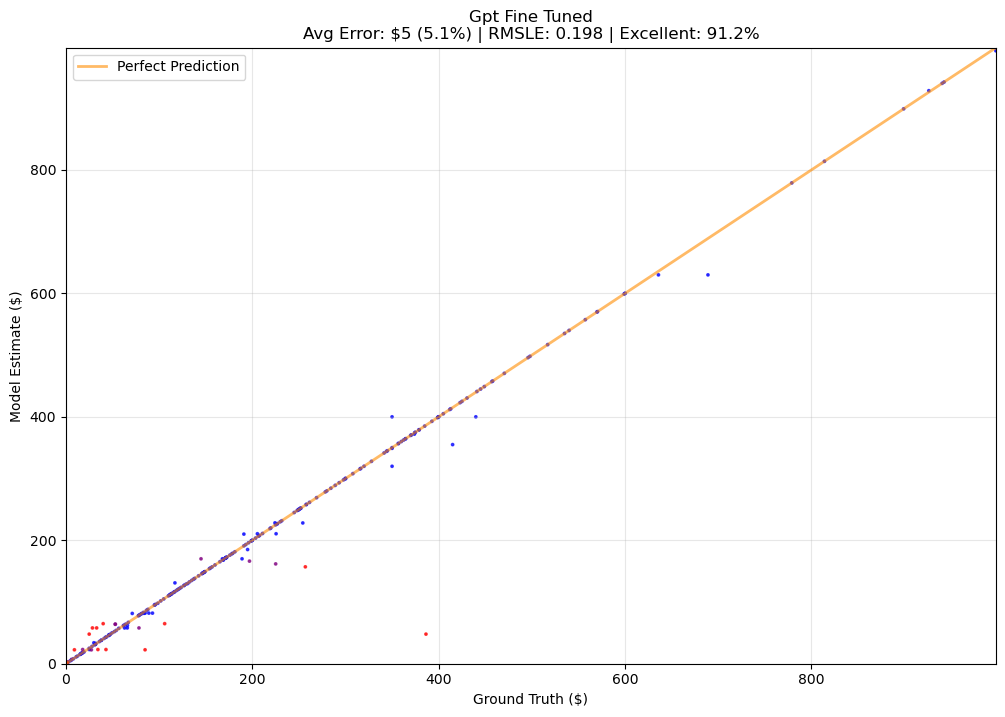

In [53]:
from dynamic_testing import Tester # Imports Tester from dynamic_testing module.

# Tester.test(my_predictor, data, excellent_threshold=0.10, good_threshold=0.25) # Example usage with custom thresholds:

Tester.test(gpt_fine_tuned, test)